# Wine Consumption and Winery Density Effects on Health and Housing



* Determine which plot would best visualize each of the 4 datasets below, and build out those plots.



In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
import scipy.stats as stats

### reading in all the data

In [2]:
total_wine_producers_df = pd.read_csv(os.path.join("..","Data","Clean",
                                                   "bonded_wine_producers_by_state_1999_june_2019_clean.csv"))
state_abbrevs = pd.read_csv(os.path.join("..","Data","Raw","state_abbrevs.csv"))
populations_df = pd.read_csv(os.path.join("..","Data","Clean",
                                          "Annual_Resident_Population_Estimates_UTF8.csv"))


### initial cleanup

In [3]:
# NAs will be filled with 0
total_wine_producers_df.fillna(0, inplace=True)
state_abbrevs.rename(columns={"State Name": "STATENAME"}, inplace=True)
# adding in the full state names to the wine producers data
total_wine_producers_df = total_wine_producers_df.merge(state_abbrevs, on="STATE", how="outer")


In [4]:
# will use these throughout analysis for the list of the states and years to focus on
state_colors = \
{
    "California": "xkcd:sky blue",
    "Colorado": "red",
    "Oregon": "purple",
    "Texas": "xkcd:burnt orange",
    "Washington": "green"
}
crash_years = [str(x) for x in range(2010, 2019,1)]

### Cleaning up state population df -- only looking at 5 states and their estimated populations from 2010-2018

In [5]:
state_populations_df = populations_df.loc[populations_df["CTYNAME"].isin(state_colors.keys()), :]
state_populations_df = state_populations_df.iloc[:, 5:18]
state_populations_df.drop(["CTYNAME","CENSUS2010POP","ESTIMATESBASE2010"], axis=1, inplace=True)
state_populations_df.rename(columns = {"STNAME":"STATENAME", "POPESTIMATE2010":"2010", 
                                       "POPESTIMATE2011":"2011", "POPESTIMATE2012":"2012", 
                                       "POPESTIMATE2013":"2013", "POPESTIMATE2014":"2014", 
                                       "POPESTIMATE2015":"2015", "POPESTIMATE2016":"2016", 
                                       "POPESTIMATE2017":"2017", "POPESTIMATE2018":"2018"}, inplace=True)
state_populations_df = state_populations_df.transpose()
state_populations_df.columns = state_populations_df.iloc[0,:]
state_populations_df.drop(state_populations_df.index[0], inplace=True)
state_populations_df

STATENAME,California,Colorado,Oregon,Texas,Washington
2010,37320903,5048281,3837532,25242679,6742902
2011,37641823,5121771,3871728,25646227,6821655
2012,37960782,5193721,3899118,26089620,6892876
2013,38280824,5270482,3922908,26489464,6962906
2014,38625139,5351218,3964106,26977142,7052439
2015,38953142,5452107,4016918,27486814,7163543
2016,39209127,5540921,4091404,27937492,7294680
2017,39399349,5615902,4146592,28322717,7425432
2018,39557045,5695564,4190713,28701845,7535591


### Initialize dataframe to store crash fatality information from one query of the API

In [7]:
# a single request to get the names of the columns
crashes_loc_base_url = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCrashesByLocation?"

crash_params = \
    {
        "fromCaseYear" : "2011",
        "toCaseYear" : "2011",
        "state" : "6",
        "county" : "",
        "format": "json"
    }
response = requests.get(crashes_loc_base_url, params=crash_params).json()
crash_df = pd.DataFrame(response["Results"][0])
# removing all rows:
crash_df = crash_df.drop(crash_df.index[:])
crash_df.head()

,CITY,CITYNAME,COUNTY,COUNTYNAME,CaseYear,FATALS,LATITUDE,LONGITUD,STATE,STATENAME,ST_CASE,TOTALVEHICLES,TWAY_ID,TWAY_ID2,VE_FORMS


### Query the National Highway Traffic Safety Administration (NHTSA) Fatality Analysis Reporting System (FARS) API

In [8]:
crashes_loc_base_url = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCrashesByLocation?"

# the API limits the number of crashes returned to 5,000 per call. This list will store the number of
# responses per call. If that number is 5000, we'll need to split up that call to get all the crashes.
nCrashes = [None]*45
c = 0
# API codes for California, Colorado,  Oregon, Texas, Washington: the states with the most wineries
state_ids = [6, 8, 41, 48, 53]
for year in range(2010, 2019, 1):
    for state in state_ids:
        crash_params = \
        {
            "fromCaseYear" : str(year),
            "toCaseYear" : str(year),
            "state" : str(state),
            "county" : "",
            "format": "json"
        }
        
        response = requests.get(crashes_loc_base_url, params=crash_params)
        response_json = response.json()
        if response.status_code == 200:
            try:
                # building the list of all fatal crashes
                crash_df = crash_df.append(response_json["Results"][0])
                nCrashes[c] = len(response_json["Results"][0])
            except IndexError: 
                continue
        c += 1

### Check for requests that hit max query limit

In [13]:
# there are no requests where the length is 5000, so we don't need to do more requests
[x for x in nCrashes if x>4999] 

[]

### Write to .csv

In [14]:
crash_df.to_csv(os.path.join("..", "Data", "Raw", "crashes_top_5_wine_states_2010-2018.csv"))

### Cleaning up crash data

In [15]:
# reading in the saved csv so we dont have to request from the API upon reopening notebook
crash_df=pd.read_csv(os.path.join("..","Data","Raw","crashes_top_5_wine_states_2010-2018.csv"))
crash_df["FATALS"] = crash_df["FATALS"].astype(int)
crash_df.drop("Unnamed: 0", axis=1, inplace=True)
crash_df.head()

,CITY,CITYNAME,COUNTY,COUNTYNAME,CaseYear,FATALS,LATITUDE,LONGITUD,STATE,STATENAME,ST_CASE,TOTALVEHICLES,TWAY_ID,TWAY_ID2,VE_FORMS
0,2150,MERCED,47,MERCED (47),2010,1,37.295019,-120.478011,6,California,60001,1,SR-99,NaN,1
1,740,CLOVIS,19,FRESNO (19),2010,1,36.816697,-119.668422,6,California,60002,1,MCKELVY AVE,NaN,1
2,0,NOT APPLICABLE,29,KERN (29),2010,3,35.614619,-119.868489,6,California,60003,3,SR-29,NaN,3
3,0,NOT APPLICABLE,107,TULARE (107),2010,1,36.026889,-118.922500,6,California,60004,2,MTN 137,NaN,2
4,0,NOT APPLICABLE,39,MADERA (39),2010,2,36.923239,-119.963281,6,California,60005,2,AVENUE 12,NaN,2


### reformatting crash data for easier plotting and to merge with wine production data and state population data

In [22]:
state_year_group = crash_df.groupby(["STATENAME", "CaseYear"])
crash_counts = state_year_group.sum()["FATALS"].reset_index()
crash_counts_pivot_state = crash_counts.pivot(index="STATENAME",columns="CaseYear",values="FATALS").reset_index()
crash_counts_pivot_state.columns = crash_counts_pivot_state.columns.astype(str)
crash_counts_pivot_state

CaseYear,STATENAME,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,California,2720,2816,2966,3107,3102,3387,3837,3884,3563
1,Colorado,450,447,474,482,488,547,608,648,632
2,Oregon,317,331,337,313,357,446,498,439,506
3,Texas,3023,3054,3408,3389,3536,3582,3797,3732,3642
4,Washington,460,454,438,436,462,551,536,563,546


### Merging wine producers, crashes, and populations into one dataframe

In [66]:
wine_crash = pd.merge(total_wine_producers_df, crash_counts_pivot_state, on="STATENAME", how="outer", 
                      suffixes=("_wine","_crash"))
wine_crash = wine_crash.loc[wine_crash["STATENAME"].isin(crash_counts_pivot_state["STATENAME"]),:]
wine_crash = wine_crash.merge(state_populations_df.transpose().reset_index(), on="STATENAME",how="outer")
wine_crash

,STATE,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2018_crash,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,CA,1364.0,1450.0,1562.0,1704.0,1869.0,2059.0,2275.0,2447.0,2687.0,...,3563.0,37320903,37641823,37960782,38280824,38625139,38953142,39209127,39399349,39557045
1,CO,31.0,34.0,40.0,45.0,52.0,60.0,66.0,70.0,82.0,...,632.0,5048281,5121771,5193721,5270482,5351218,5452107,5540921,5615902,5695564
2,OR,126.0,145.0,164.0,192.0,214.0,250.0,291.0,318.0,351.0,...,506.0,3837532,3871728,3899118,3922908,3964106,4016918,4091404,4146592,4190713
3,TX,64.0,67.0,68.0,77.0,86.0,110.0,141.0,159.0,181.0,...,3642.0,25242679,25646227,26089620,26489464,26977142,27486814,27937492,28322717,28701845
4,WA,163.0,182.0,231.0,268.0,325.0,376.0,454.0,527.0,578.0,...,546.0,6742902,6821655,6892876,6962906,7052439,7163543,7294680,7425432,7535591


### Linear Regression for Crash Fatalities vs. Number of Wine Producers

In [94]:
w = wine_crash.loc[:, [x + "_wine" for x in crash_years]].values.flatten()
cr = wine_crash.loc[:, [x + "_crash" for x in crash_years]].values.flatten()*100000/wine_crash.loc[:, crash_years].values.flatten()
# There is actually a negative correlation between wine production and crash fatalities
wine_crash_regression = stats.linregress(w,cr.astype(float))
wine_crash_regression

LinregressResult(slope=-0.00042238991092123873, intercept=10.108644009351472, rvalue=-0.29579667260025694, pvalue=0.04851596515416, stderr=0.00020801923298814087)

### Plots

C:\Users\epayn\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


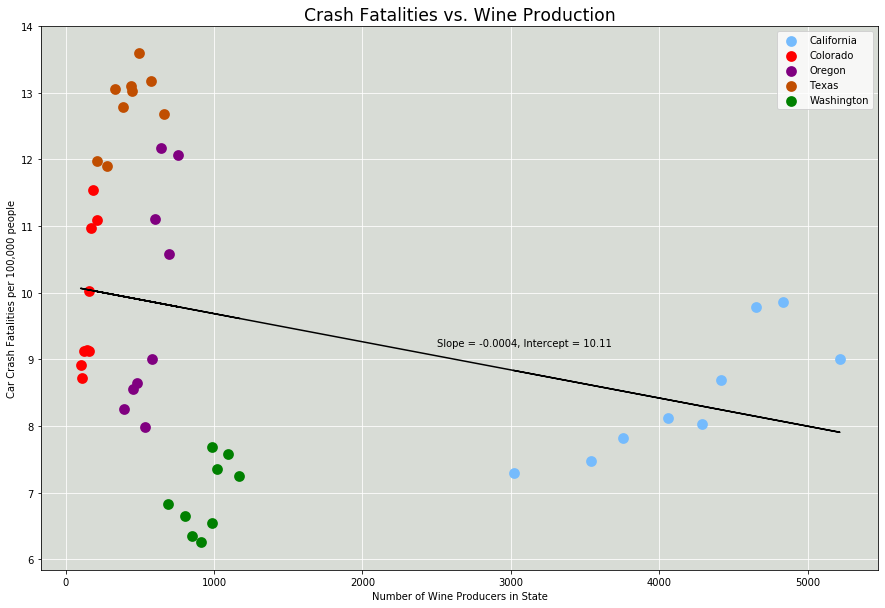

In [102]:
plt.figure(figsize=(15,10), facecolor="w")
plt.title("Crash Fatalities vs. Wine Production", size="xx-large")
axes = plt.axes()

axes.set_facecolor("xkcd:light grey")
axes.set_axisbelow(True)
axes.grid(axis="both", color = "w")

axes.set_xlabel("Number of Wine Producers in State")
axes.set_ylabel("Car Crash Fatalities per 100,000 people")

for state in state_colors.keys():
    
    staterow = wine_crash["STATENAME"]==state
    
    # transposing these so that the scatter plot will accept them as arguments
    wineprods = wine_crash.loc[staterow, [x + "_wine" for x in crash_years]].transpose()
    crashes = wine_crash.loc[staterow, [x + "_crash" for x in crash_years]].transpose()
    pops = wine_crash.loc[staterow, crash_years].transpose()

    plt.scatter(wineprods.values, crashes.values*100000/pops.values, c=state_colors[state], 
                label=state, linewidth=3, s=60)
    plt.legend(loc="upper right")

# here w is the list of all wine producers, used previously for the regression
plt.plot(w, w*wine_crash_regression[0] + wine_crash_regression[1], c="black")
plt.annotate(f"Slope = {round(wine_crash_regression[0],4)}," + \
             f" Intercept = {round(wine_crash_regression[1],2)}", 
             (2500, 9.2))

plt.savefig(os.path.join("..","Images", "Crash Fatalities vs. Wine Production Among Top 5 States.png"))

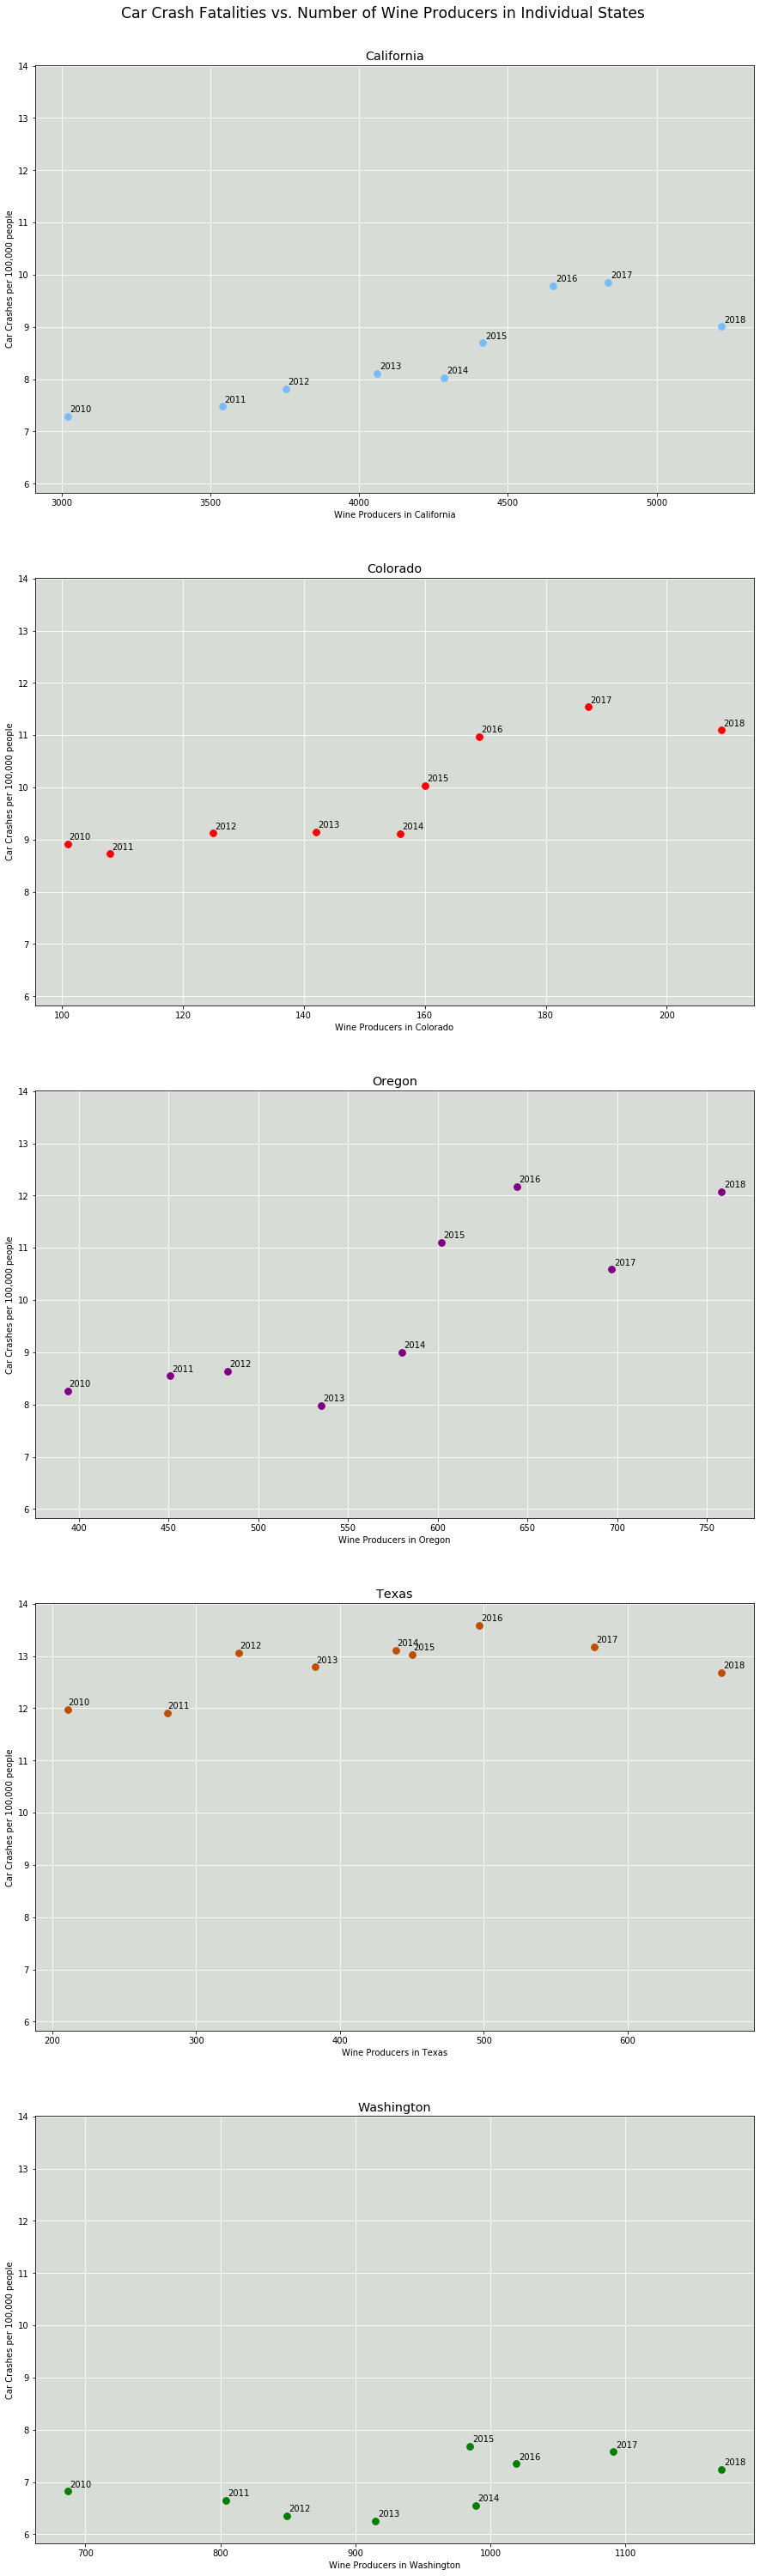

In [78]:
# 5 subplots for 5 states
fig, axes = plt.subplots(5, sharey=True, figsize=(15,48), facecolor="w")

for i in range(axes.shape[0]):
    ax = axes[i]
    
    # state name and its boolean index
    state = wine_crash["STATENAME"].values[i]
    staterow = wine_crash["STATENAME"]==state
    
    # transposing these so that the scatter plot will accept them as arguments
    wineprods = wine_crash.loc[staterow, [x + "_wine" for x in crash_years]].transpose()
    crashes = wine_crash.loc[staterow, [x + "_crash" for x in crash_years]].transpose()
    pops = wine_crash.loc[staterow, crash_years].transpose()
    
    # plot the rate per 100,000 residents
    ax.scatter(wineprods, crashes.values*100000/pops.values, c=state_colors[state], label=state, s=60)

    ax.set_facecolor("xkcd:light grey")
    ax.set_axisbelow(True)
    ax.grid(axis="both", color = "w")

    ax.set_title(f"{state}", size = "x-large")
    ax.set_xlabel(f"Wine Producers in {state}")
    ax.set_ylabel("Car Crashes per 100,000 people")
    
    for i in range(len(wineprods)):
        ax.annotate(crash_years[i], (wineprods.values[i] + max(wineprods.values[i])/530, 
                                     crashes.values[i]*100000/pops.values[i] + .08))
    
fig.suptitle("Car Crash Fatalities vs. Number of Wine Producers in Individual States",
            size="xx-large")
fig.subplots_adjust(top=.96)

plt.savefig(os.path.join("..","Images","Car Crash Fatalities vs. Number of Wine Producers in Individual States.png"))

LinregressResult(slope=-4.223899109212386e-09, intercept=0.00010108644009351472, rvalue=-0.2957966726002569, pvalue=0.04851596515416006, stderr=2.0801923298814086e-09)